<a href="https://colab.research.google.com/github/Codechickdev/ML_Projects/blob/main/Fashion_MNIST_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

%matplotlib inline

In [2]:
dataset = FashionMNIST(root = 'data/', download = True, transform = ToTensor())
test_dataset = FashionMNIST(root = 'data/', train = False, transform = ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [5]:
batch_size = 128

In [7]:
train_loader = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)
test_loader = DataLoader(test_dataset, batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Image Shape: torch.Size([128, 1, 28, 28])


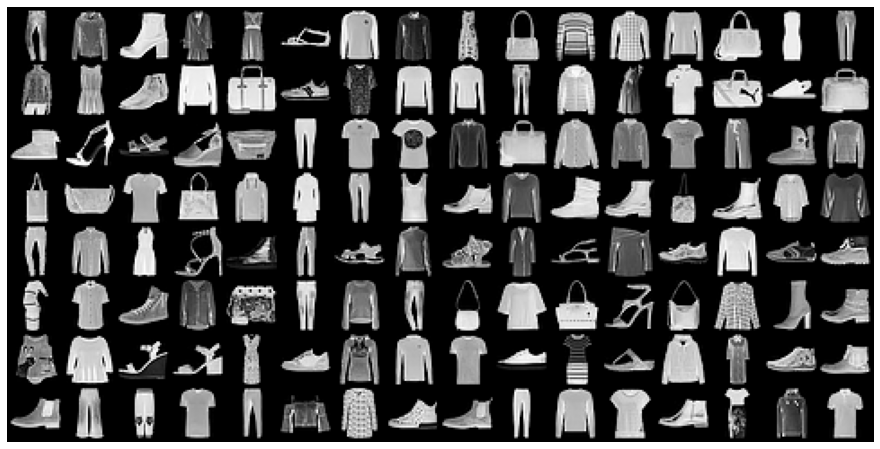

In [12]:
for image, _ in train_loader:
    print(f"Image Shape: {image.shape}")
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(image, nrow=16).permute((1, 2, 0)))
    break

In [15]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [21]:
for images, labels in train_loader:
    print(images.size())
    print(images.view(labels.size(0), -1).size())
    print(labels.size())
    print(labels.view(labels.size(0), -1).size())
    break

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([128, 1, 28, 28])
torch.Size([128, 784])
torch.Size([128])
torch.Size([128, 1])


In [60]:
class MnistModel(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, 16)
        self.linear2 = nn.Linear(16, 32)
        self.linear3 = nn.Linear(32, 64)
        self.linear4 = nn.Linear(64, out_size)
    
    def forward(self, xb):
        out = xb.view(xb.size(0), -1)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                  
        loss = F.cross_entropy(out, labels) 
        acc = accuracy(out, labels)         
        return {'Val_Loss': loss, 'Val_Acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['Val_Loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['Val_Acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {"Val_Loss" : epoch_loss.item(), "Val_Acc" : epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['Val_Loss'], result['Val_Acc']))

In [49]:
torch.cuda.is_available()

True

In [50]:
def get_default_devices():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [51]:
device = get_default_devices()
device

device(type='cuda')

In [52]:
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

In [53]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
        
    def __len__(self):
        return len(self.dl)

In [54]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [55]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [56]:
input_size = 784
num_classes = 10

In [61]:
model = MnistModel(in_size = input_size, out_size = num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=64, bias=True)
  (linear4): Linear(in_features=64, out_features=10, bias=True)
)

In [58]:
history = [evaluate(model, val_loader)]
history

[{'Val_Loss': 2.3077409267425537, 'Val_Acc': 0.07333984225988388}]

In [62]:
history += fit(5, 0.5, model, train_loader, val_loader)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], val_loss: 1.1066, val_acc: 0.5354
Epoch [1], val_loss: 0.9610, val_acc: 0.5896
Epoch [2], val_loss: 0.9425, val_acc: 0.5786
Epoch [3], val_loss: 1.1132, val_acc: 0.5061
Epoch [4], val_loss: 0.9192, val_acc: 0.6262


In [63]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8171, val_acc: 0.6604
Epoch [1], val_loss: 0.7242, val_acc: 0.7130
Epoch [2], val_loss: 0.6756, val_acc: 0.7493
Epoch [3], val_loss: 0.6522, val_acc: 0.7579
Epoch [4], val_loss: 0.6622, val_acc: 0.7618


In [67]:
history += fit(10, 0.1, model, train_loader, val_loader)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], val_loss: 0.7188, val_acc: 0.7373
Epoch [1], val_loss: 0.6198, val_acc: 0.7748
Epoch [2], val_loss: 0.5940, val_acc: 0.7837
Epoch [3], val_loss: 0.6134, val_acc: 0.7752
Epoch [4], val_loss: 0.6291, val_acc: 0.7672
Epoch [5], val_loss: 0.5855, val_acc: 0.7904
Epoch [6], val_loss: 0.5778, val_acc: 0.7964
Epoch [7], val_loss: 0.5779, val_acc: 0.7974
Epoch [8], val_loss: 0.6078, val_acc: 0.7849
Epoch [9], val_loss: 0.6036, val_acc: 0.7873


In [71]:
history += fit(10, 0.5, model, train_loader, val_loader)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [0], val_loss: 0.7553, val_acc: 0.7194
Epoch [1], val_loss: 0.8517, val_acc: 0.6569
Epoch [2], val_loss: 1.5040, val_acc: 0.4498
Epoch [3], val_loss: 0.6103, val_acc: 0.7626
Epoch [4], val_loss: 0.6637, val_acc: 0.7499
Epoch [5], val_loss: 0.5812, val_acc: 0.7721
Epoch [6], val_loss: 0.6298, val_acc: 0.7370
Epoch [7], val_loss: 0.5893, val_acc: 0.7796
Epoch [8], val_loss: 0.6486, val_acc: 0.7574
Epoch [9], val_loss: 0.7857, val_acc: 0.6954


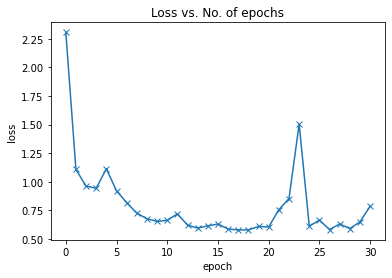

In [72]:
losses = [x['Val_Loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

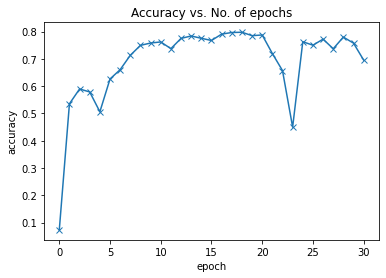

In [73]:
accuracies = [x['Val_Acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [70]:
saved_weights_fname='fashion-feedforward.pth'

In [75]:
torch.save(model.state_dict(), saved_weights_fname)